In [53]:
%pylab inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os
import glob
from tqdm import tqdm
import pandas as pd
import fitsne
from sklearn.model_selection import cross_val_score

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from skimage.color import rgb2gray

from pywsi.io import WSIReader
from pywsi.io.operations import read_as_rgb

from pywsi.segmentation import poisson_deconvolve, perform_binary_cut, max_clustering
from pywsi.segmentation import collapse_labels, collapse_small_area, laplace_of_gaussian
from pywsi.segmentation import gmm_thresholding, label_nuclei, extract_features, summarize_region_properties

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization
from pywsi.normalization import VahadaneNormalization
from pywsi.normalization import XuNormalization

from sklearn.decomposition import PCA, FastICA
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import umap
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from tpot import TPOTClassifier


scaler = StandardScaler()

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/'
tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/tumor_patches_test/level_0/'

np.random.seed(42)
list_of_tumor_files = list(glob.glob('{}*.png'.format(tumor_patches_dir)))
list_of_normal_files = list(glob.glob('{}*.png'.format(normal_patches_dir)))

list_of_tumor_files = list(np.random.choice(list_of_tumor_files, 1000))
list_of_normal_files = list(np.random.choice(list_of_normal_files, 1000))



In [10]:
def draw_nuclei(patch, local_max_search_radius=3, min_radius=5, max_radius=15, min_nucleus_area=100):
    patch = read_as_rgb(patch)
    label_nuclei(patch,
                 local_max_search_radius=local_max_search_radius, 
                 min_radius=min_radius,
                 max_radius=max_radius, 
                 min_nucleus_area=min_nucleus_area)
    

In [11]:
interact(draw_nuclei, patch=list_of_tumor_files+list_of_normal_files)


interactive(children=(Dropdown(description='patch', options=('/Z/personal-folders/interns/saket/histopath_data…

<function __main__.draw_nuclei(patch, local_max_search_radius=3, min_radius=5, max_radius=15, min_nucleus_area=100)>

In [12]:
patch = read_as_rgb(list_of_tumor_files[0])

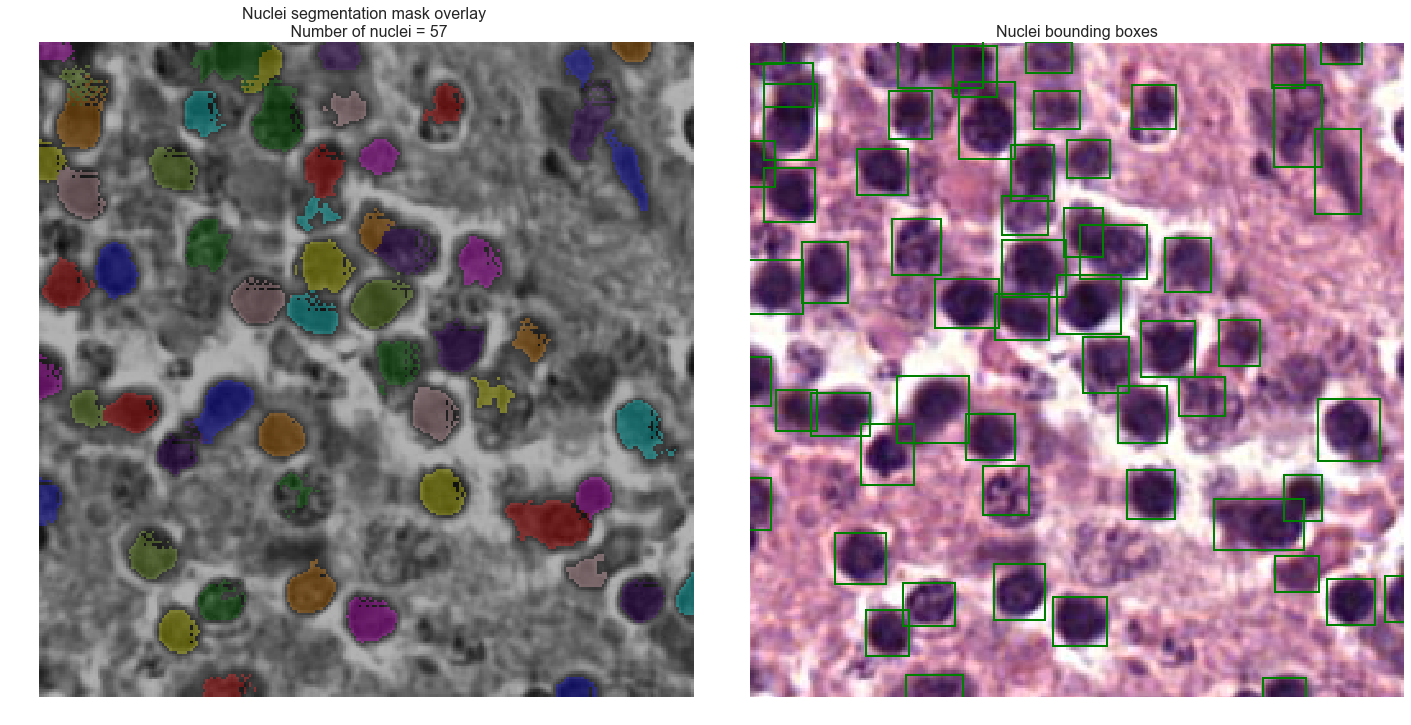

In [13]:
region_properties, fg_mask = label_nuclei(patch)

In [18]:
features_df = []
labels = []
for sample in tqdm(list_of_normal_files):
    patch = read_as_rgb(sample)
    region_properties, _ = label_nuclei(patch, draw=False) 
    summary = summarize_region_properties(region_properties, 
                                          patch)
    if summary is None:
        print('Nothing found for {}'.format(sample))
        continue
    labels.append('normal')
    features_df.append(summary)


  1%|          | 8/1000 [00:08<17:11,  1.04s/it]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/saket/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/saket/anaconda3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 36%|███▌      | 362/1000 [05:12<09:11,  1.16it/s]

Nothing found for /Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/tumor_048_33856_186816_256.png


 57%|█████▋    | 574/1000 [08:21<06:12,  1.14it/s]

Nothing found for /Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/tumor_052_18752_57280_256.png


100%|██████████| 1000/1000 [14:39<00:00,  1.14it/s]


In [19]:
for sample in tqdm(list_of_tumor_files):
    patch = read_as_rgb(sample)
    region_properties, _ = label_nuclei(patch, draw=False) 
    summary = summarize_region_properties(region_properties, 
                                          patch)
    if summary is None:
        print('Nothing found for {}'.format(sample))
        continue
    labels.append('tumor')
    features_df.append(summary)

100%|██████████| 1000/1000 [13:46<00:00,  1.21it/s]


In [29]:
#tfile = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/tumor_048_33856_186816_256.png'
y = np.array([1  if label=='normal' else 0 for label in labels])

In [23]:
f = pd.DataFrame(features_df)
X = f.values

In [25]:
X_scaled = scaler.fit(X).transform(X)

In [28]:
X_scaled.shape

(1998, 46)

# PCA

We start of with doing PCA/tSNE on the features.


In [ ]:
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2))
std_clf.fit(X)



explained variance ratio (first two components): [0.34548085 0.13139061]


Text(0.5,1,'PCA ')

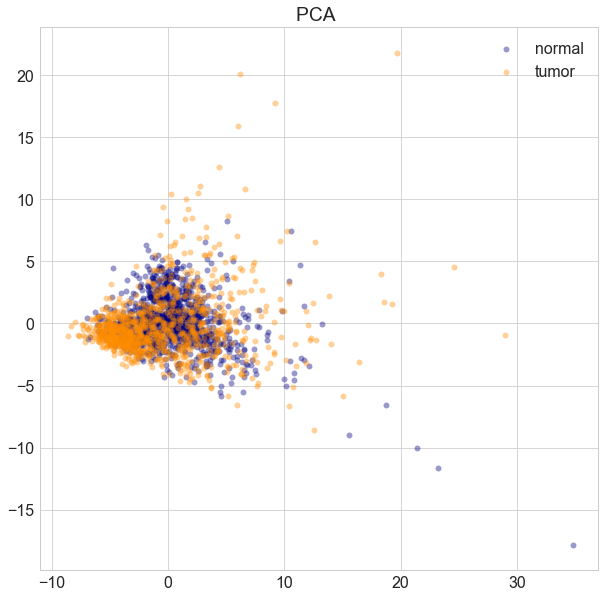

In [30]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)


# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure(figsize=(10, 10))
colors = ['navy', 'darkorange']
lw = 0.2
label_matrix = ['normal', 'tumor']
for color, i, target_name in zip(colors, [0, 1], label_matrix):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.4, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA ')

# UMAP

Text(0.5,1,'UMAP')

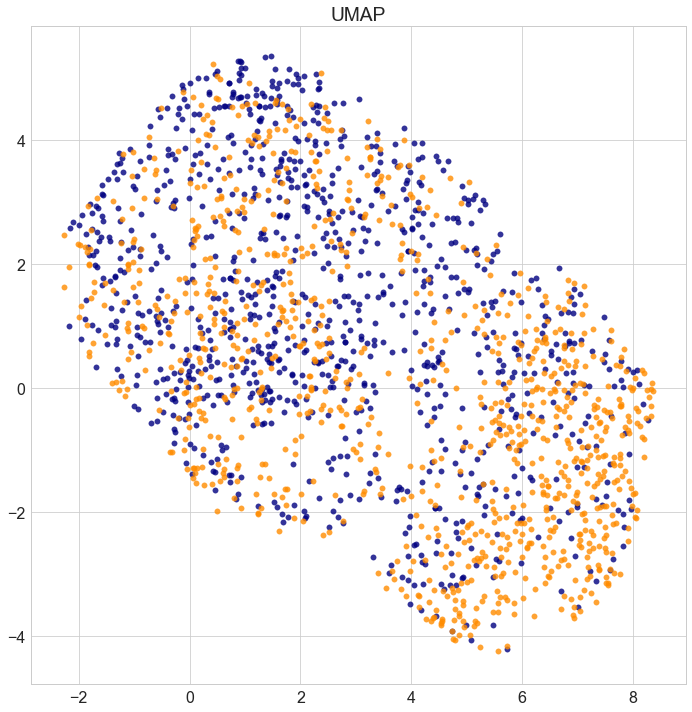

In [31]:

embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 10))

for color, i, target_name in zip(colors, [0, 1], label_matrix):
    plt.scatter(embedding[y == i, 0], embedding[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
fig.tight_layout()
plt.title('UMAP')

In [35]:
Y = fitsne.FItSNE(X_scaled.copy(order='C'))# max_iter=500)

Text(0.5,1,'FIt-SNE')

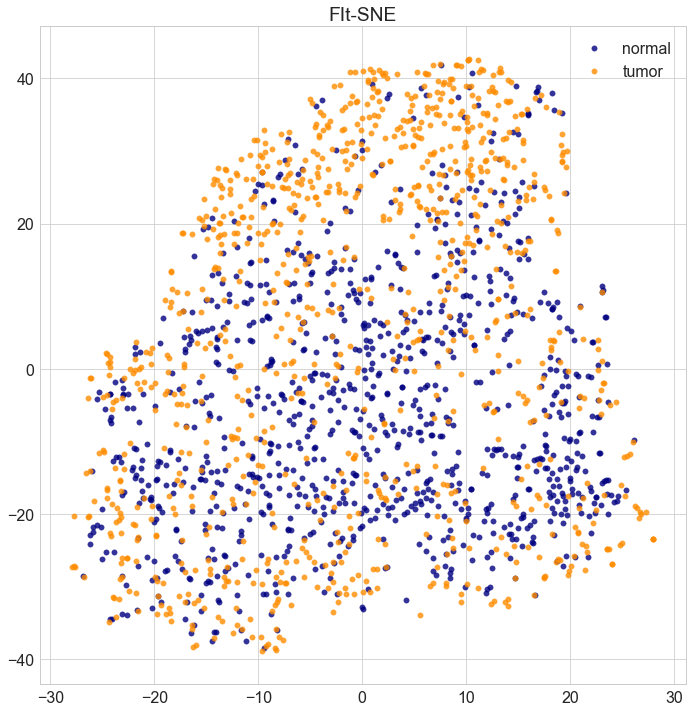

In [36]:
colors = ['navy', 'darkorange']
lw = 0.2
label_matrix = ['normal', 'tumor']

fig = plt.figure(figsize=(10, 10))
for color, i, target_name in zip(colors, [0, 1], label_matrix):
    plt.scatter(Y[y == i, 0], Y[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

fig.tight_layout()
plt.title('FIt-SNE')

# Random Forest

In [37]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=40)
print(clf.feature_importances_)

# LASSO

In [40]:
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)

In [42]:
r2_score_lasso

0.007658665709932455

In [49]:
alpha = 0.001
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
r2_score_enet

0.20623647396764422

In [55]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)


[autoreload of sklearn.ensemble.bagging failed: Traceback (most recent call last):
  File "/home/saket/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/saket/anaconda3/lib/python3.5/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/saket/anaconda3/lib/python3.5/importlib/__init__.py", line 159, in reload
    name=parent_name) from None
ImportError: parent 'sklearn.ensemble' not in sys.modules
]
[autoreload of sklearn.ensemble.base failed: Traceback (most recent call last):
  File "/home/saket/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.

Generation 1 - Current best internal CV score: 0.7317511520737329


Optimization Progress:  50%|█████     | 60/120 [01:51<01:31,  1.52s/pipeline]

Generation 2 - Current best internal CV score: 0.7374807987711214


Optimization Progress:  67%|██████▋   | 80/120 [03:00<04:23,  6.59s/pipeline]

Generation 3 - Current best internal CV score: 0.7374807987711214


Optimization Progress:  83%|████████▎ | 100/120 [05:35<01:09,  3.47s/pipeline]

Generation 4 - Current best internal CV score: 0.7381899641577061


Generation 5 - Current best internal CV score: 0.741047107014849

Best pipeline: RandomForestClassifier(ZeroCount(input_matrix), bootstrap=True, criterion=entropy, max_features=0.4, min_samples_leaf=11, min_samples_split=19, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.preprocessing.StandardScaler': {}, 'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'], 'linkage': ['ward', 'complete', 'average']}, 'sklearn.ensemble.GradientBoostingClassifier': {'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.2... 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=5, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=20, periodic_checkpoint_folder=None,
        population_size=20, random_state=42, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

In [56]:
print(pipeline_optimizer.score(X_test, y_test))


0.7333333333333333
